# XGBoost 분류 문제 예제

보통 `xgb`로 불러서 사용합니다.

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import requests

import pandas as pd
import seaborn as sns
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from xgboost import XGBClassifier

from sklearn.experimental import enable_hist_gradient_boosting  # isort:skip
from sklearn.ensemble import HistGradientBoostingClassifier  # isort:skip

%matplotlib inline
%config InlineBackend.figure_formats = {"png", "retina"}
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["figure.constrained_layout.use"] = True
pd.plotting.register_matplotlib_converters()

In [2]:
data_dir = Path() / "data"
data_dir.mkdir(parents=True, exist_ok=True)

## 데이터 준비

[타이타닉 데이터셋](https://github.com/alexisperrier/packt-aml/blob/master/ch4/titanic.csv)을 이용합니다.

In [3]:
# Download and save the file
titanic_path = data_dir / "titanic.csv"

if not titanic_path.exists():
    response = requests.get(
        "https://raw.githubusercontent.com/alexisperrier/packt-aml/master/ch4/titanic.csv"
    )
    with open(titanic_path, "wb") as f:
        f.write(response.content)

In [4]:
titanic_temp = pd.read_csv(titanic_path)

titanic_temp

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,3,0,Mahon Miss. Bridget Delia,female,NaN,0,0,330924,7.8792,NaN,Q,NaN,NaN,NaN
1,1,0,Clifford Mr. George Quincy,male,NaN,0,0,110465,52.0000,A14,S,NaN,NaN,Stoughton MA
2,3,0,Yasbeck Mr. Antoni,male,27.0,1,0,2659,14.4542,NaN,C,C,NaN,NaN
3,3,1,Tenglin Mr. Gunnar Isidor,male,25.0,0,0,350033,7.7958,NaN,S,13 15,NaN,NaN
4,3,0,Kelly Mr. James,male,34.5,0,0,330911,7.8292,NaN,Q,NaN,70.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,Rice Master. Eugene,male,2.0,4,1,382652,29.1250,NaN,Q,NaN,NaN,NaN
1305,3,0,Dika Mr. Mirko,male,17.0,0,0,349232,7.8958,NaN,S,NaN,NaN,NaN
1306,3,0,Palsson Miss. Torborg Danira,female,8.0,3,1,349909,21.0750,NaN,S,NaN,NaN,NaN
1307,1,0,Widener Mr. George Dunton,male,50.0,1,1,113503,211.5000,C80,C,NaN,NaN,Elkins Park PA


In [5]:
titanic_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [6]:
titanic_temp.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [7]:
titanic_temp["pclass"]

0       3
1       1
2       3
3       3
4       3
       ..
1304    3
1305    3
1306    3
1307    1
1308    3
Name: pclass, Length: 1309, dtype: int64

In [8]:
titanic_temp["pclass"].unique()

array([3, 1, 2], dtype=int64)

In [9]:
titanic_temp["pclass"].value_counts()

3    709
1    323
2    277
Name: pclass, dtype: int64

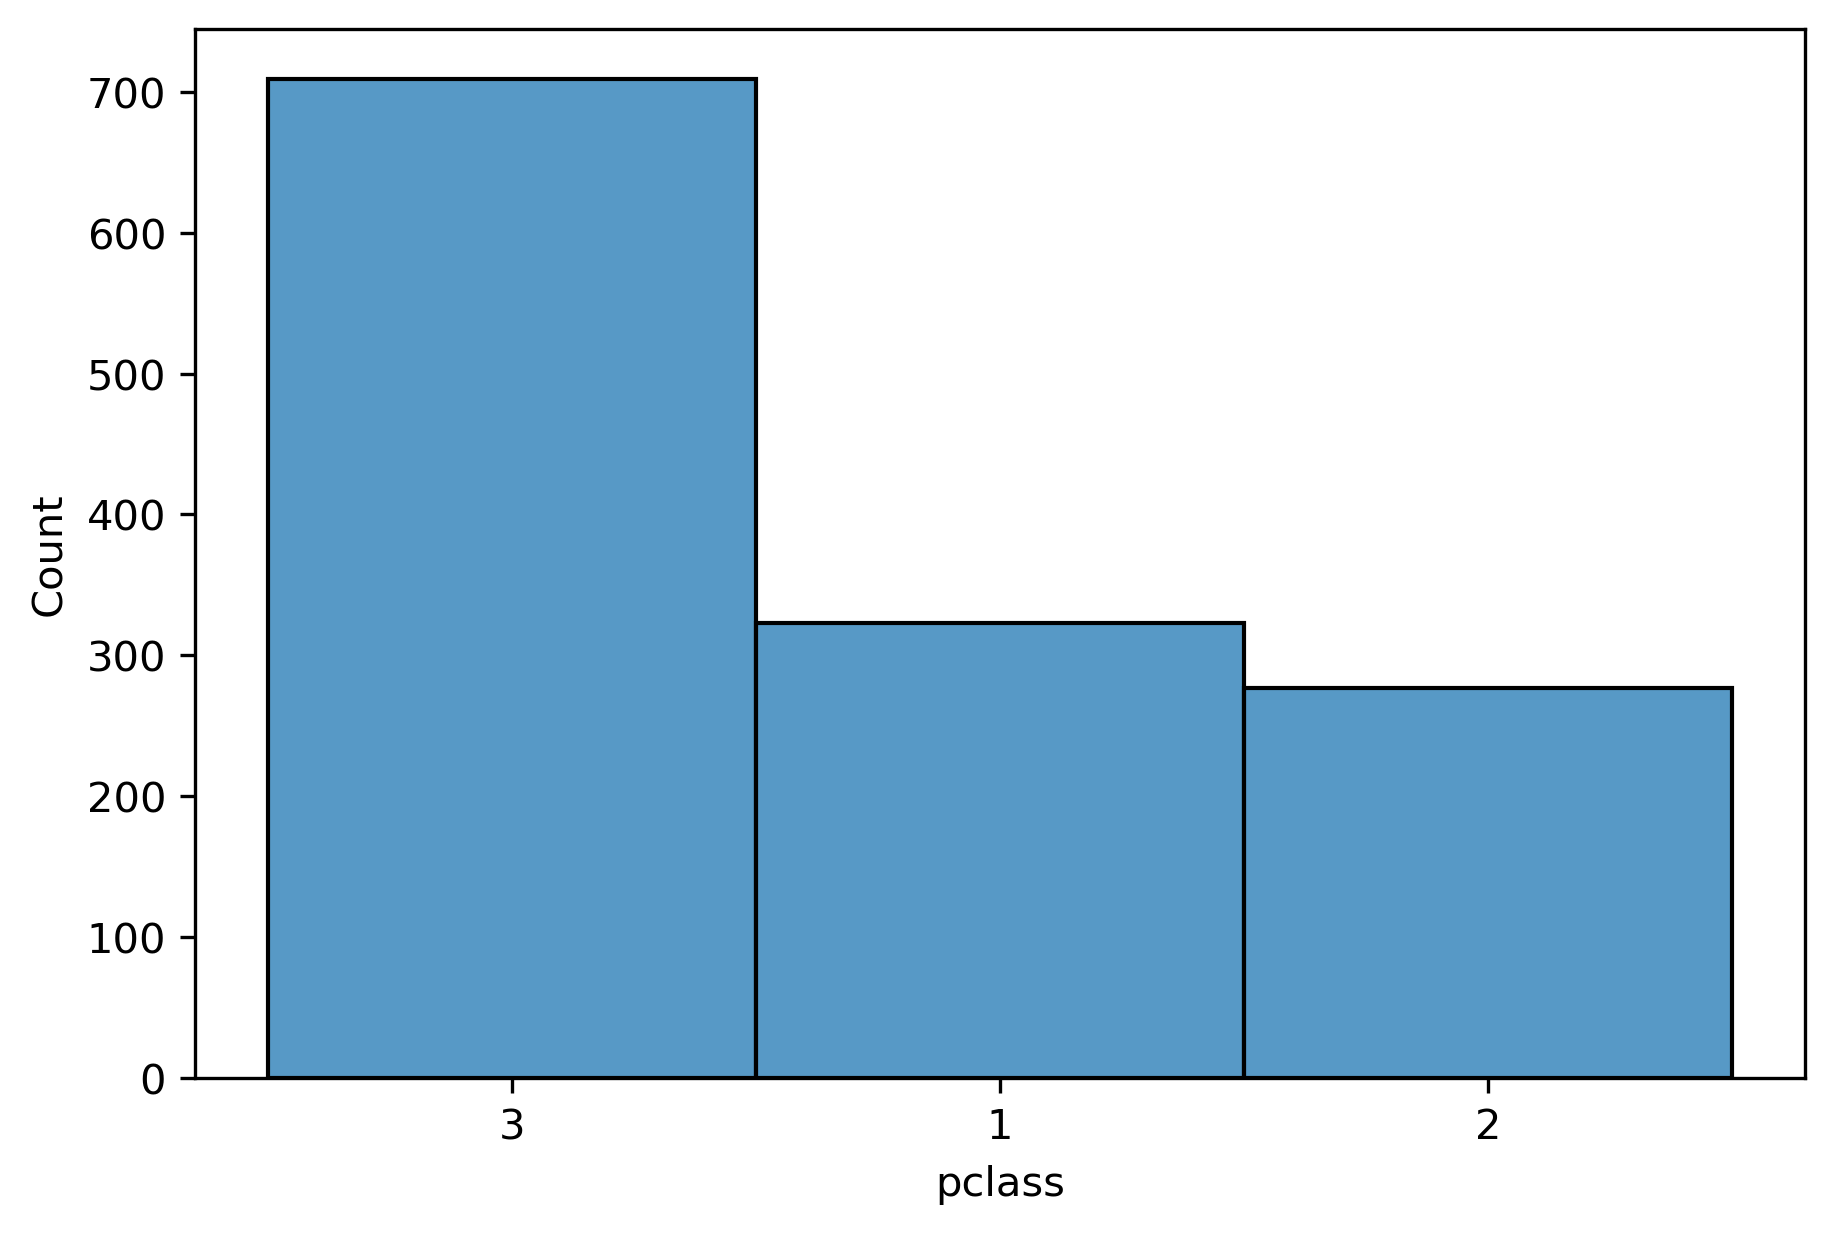

In [10]:
fig, ax = plt.subplots()

sns.histplot(titanic_temp["pclass"].astype(str))
pass

In [11]:
titanic_temp["sex"].unique()

array(['female', 'male'], dtype=object)

In [12]:
titanic_temp["sex"].value_counts()

male      843
female    466
Name: sex, dtype: int64

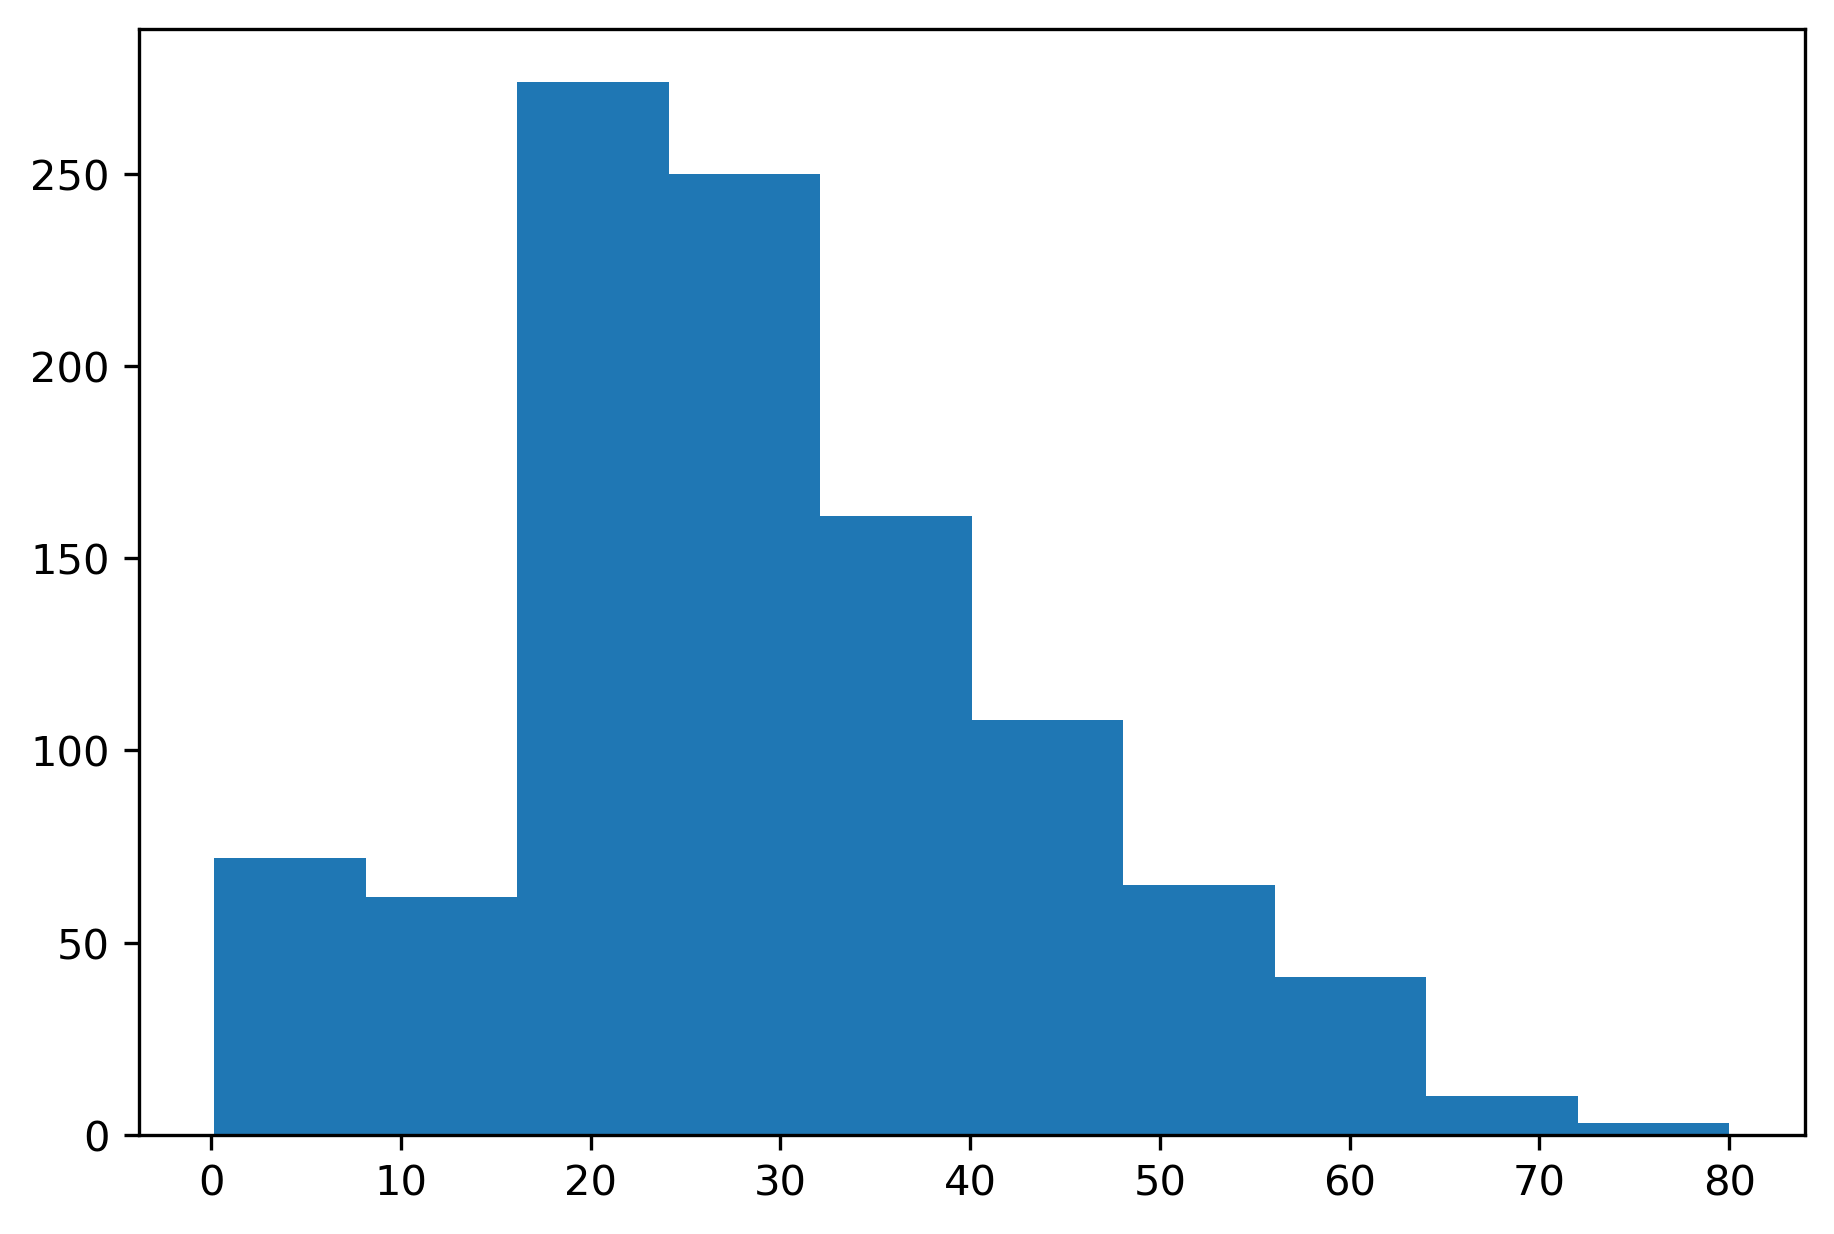

In [13]:
fig, ax = plt.subplots()

ax.hist(titanic_temp["age"])
pass

In [14]:
titanic_temp["fare"].value_counts()

8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
4.0125      1
9.6875      1
25.9250     1
12.2750     1
9.4750      1
Name: fare, Length: 281, dtype: int64

In [15]:
titanic_temp.isna().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

피처 중 `fare`와 `embarked`는 결손치가 각각 1개, 2개가 있는데, 결손치가 있는 데이터는 아예 제외하겠습니다.
`age`에는 결손치가 많이 있고, 따로 처리하지 않고 그대로 사용합니다.

In [16]:
numeric_feature_names = ["age", "sibsp", "parch", "fare"]
categorical_feature_names = ["pclass", "sex", "embarked"]
feature_names = numeric_feature_names + categorical_feature_names
target_name = "survived"

In [17]:
titanic_raw = (
    pd.read_csv(
        titanic_path,
        usecols=(feature_names + [target_name]),
        dtype={
            **{k: "category" for k in categorical_feature_names},
            "survived": float,
        },
    )
    .dropna(subset=["fare", "embarked"])
    .reset_index(drop=True)
    .reindex(columns=(feature_names + [target_name]))
)

titanic_raw.info()
titanic_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1043 non-null   float64 
 1   sibsp     1306 non-null   int64   
 2   parch     1306 non-null   int64   
 3   fare      1306 non-null   float64 
 4   pclass    1306 non-null   category
 5   sex       1306 non-null   category
 6   embarked  1306 non-null   category
 7   survived  1306 non-null   float64 
dtypes: category(3), float64(3), int64(2)
memory usage: 55.2 KB


,age,sibsp,parch,fare,pclass,sex,embarked,survived
0,NaN,0,0,7.8792,3,female,Q,0.0
1,NaN,0,0,52.0000,1,male,S,0.0
2,27.0,1,0,14.4542,3,male,C,0.0
3,25.0,0,0,7.7958,3,male,S,1.0
4,34.5,0,0,7.8292,3,male,Q,0.0


피처의 타입별로 데이터를 확인할 수 있습니다.

In [18]:
titanic_raw.select_dtypes("number")

,age,sibsp,parch,fare,survived
0,NaN,0,0,7.8792,0.0
1,NaN,0,0,52.0000,0.0
2,27.0,1,0,14.4542,0.0
3,25.0,0,0,7.7958,1.0
4,34.5,0,0,7.8292,0.0
...,...,...,...,...,...
1301,2.0,4,1,29.1250,0.0
1302,17.0,0,0,7.8958,0.0
1303,8.0,3,1,21.0750,0.0
1304,50.0,1,1,211.5000,0.0


In [19]:
titanic_raw.select_dtypes(exclude="number")

,pclass,sex,embarked
0,3,female,Q
1,1,male,S
2,3,male,C
3,3,male,S
4,3,male,Q
...,...,...,...
1301,3,male,Q
1302,3,male,S
1303,3,female,S
1304,1,male,C


카테고리를 확인합니다.

In [20]:
for c, series in titanic_raw.select_dtypes("category").items():
    print(c, series.cat.categories)

pclass Index(['1', '2', '3'], dtype='object')
sex Index(['female', 'male'], dtype='object')
embarked Index(['C', 'Q', 'S'], dtype='object')


학습 세트와 평가 세트로 분할합니다.

In [21]:
(
    x_train_raw,
    x_test_raw,
    y_train_raw,
    y_test_raw,
) = sklearn.model_selection.train_test_split(
    titanic_raw[feature_names],
    titanic_raw[target_name],
    test_size=0.2,
    random_state=78,
)

In [22]:
x_train_raw.shape, x_test_raw.shape, y_train_raw.shape, y_test_raw.shape

((1044, 7), (262, 7), (1044,), (262,))

## 데이터 전처리

트리 모델이라 수치 데이터의 정규화는 하지 않고, 범주형 데이터의 one-hot 인코딩만 진행합니다.

Scikit-learn에서 제공하는 `ColumnTransformer`, [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) 등을 쓸 수도 있지만, 열 이름을 다 떼어 버리기 때문에, 여기서는 `pd.get_dummies`를 이용하겠습니다.

원래는 fit-transform 과정을 거쳐야 하지만, 간단하게 하기 위해 이미 정보를 안다고 가정하고 수동으로 처리하겠습니다.

- `pclass`: 1, 2, 3
- `sex`: `female`, `male` 2가지이지만, 2열로 하지 않고 `male`은 떼어 버림
- `embarked`: C, Q, S

In [23]:
def titanic_one_hot_encoder(x, y=None):
    numeric_df = x[numeric_feature_names]
    one_hot_encoded_df = (
        pd.get_dummies(x[categorical_feature_names])
        .drop(columns="sex_male")
        .rename(columns=str.lower)
    )
    new_x = pd.concat((numeric_df, one_hot_encoded_df), axis=1)
    return new_x

In [24]:
x_train = titanic_one_hot_encoder(x_train_raw)
x_test = titanic_one_hot_encoder(x_test_raw)
y_train = y_train_raw.copy()
y_test = y_test_raw.copy()

display(x_train.head())
display(x_test.head())

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,embarked_c,embarked_q,embarked_s
872,50.0,1,0,26.0000,0,1,0,0,0,0,1
1251,50.0,0,1,247.5208,1,0,0,1,1,0,0
771,NaN,0,0,31.6833,1,0,0,1,0,0,1
574,36.0,1,0,26.0000,0,1,0,1,0,0,1
786,39.0,0,0,7.9250,0,0,1,0,0,0,1


,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,embarked_c,embarked_q,embarked_s
644,1.0,0,2,37.0042,0,1,0,0,1,0,0
1144,36.0,1,0,17.4000,0,0,1,1,0,0,1
900,51.0,0,0,12.5250,0,1,0,0,0,0,1
398,18.0,0,0,6.7500,0,0,1,1,0,1,0
457,25.0,0,0,7.8958,0,0,1,0,0,0,1


⚠️ [Min-max scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), [정규화](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) 등을 할 때엔, 학습 세트와 평가 세트를 따로 하지 않도록 조심해야 합니다.

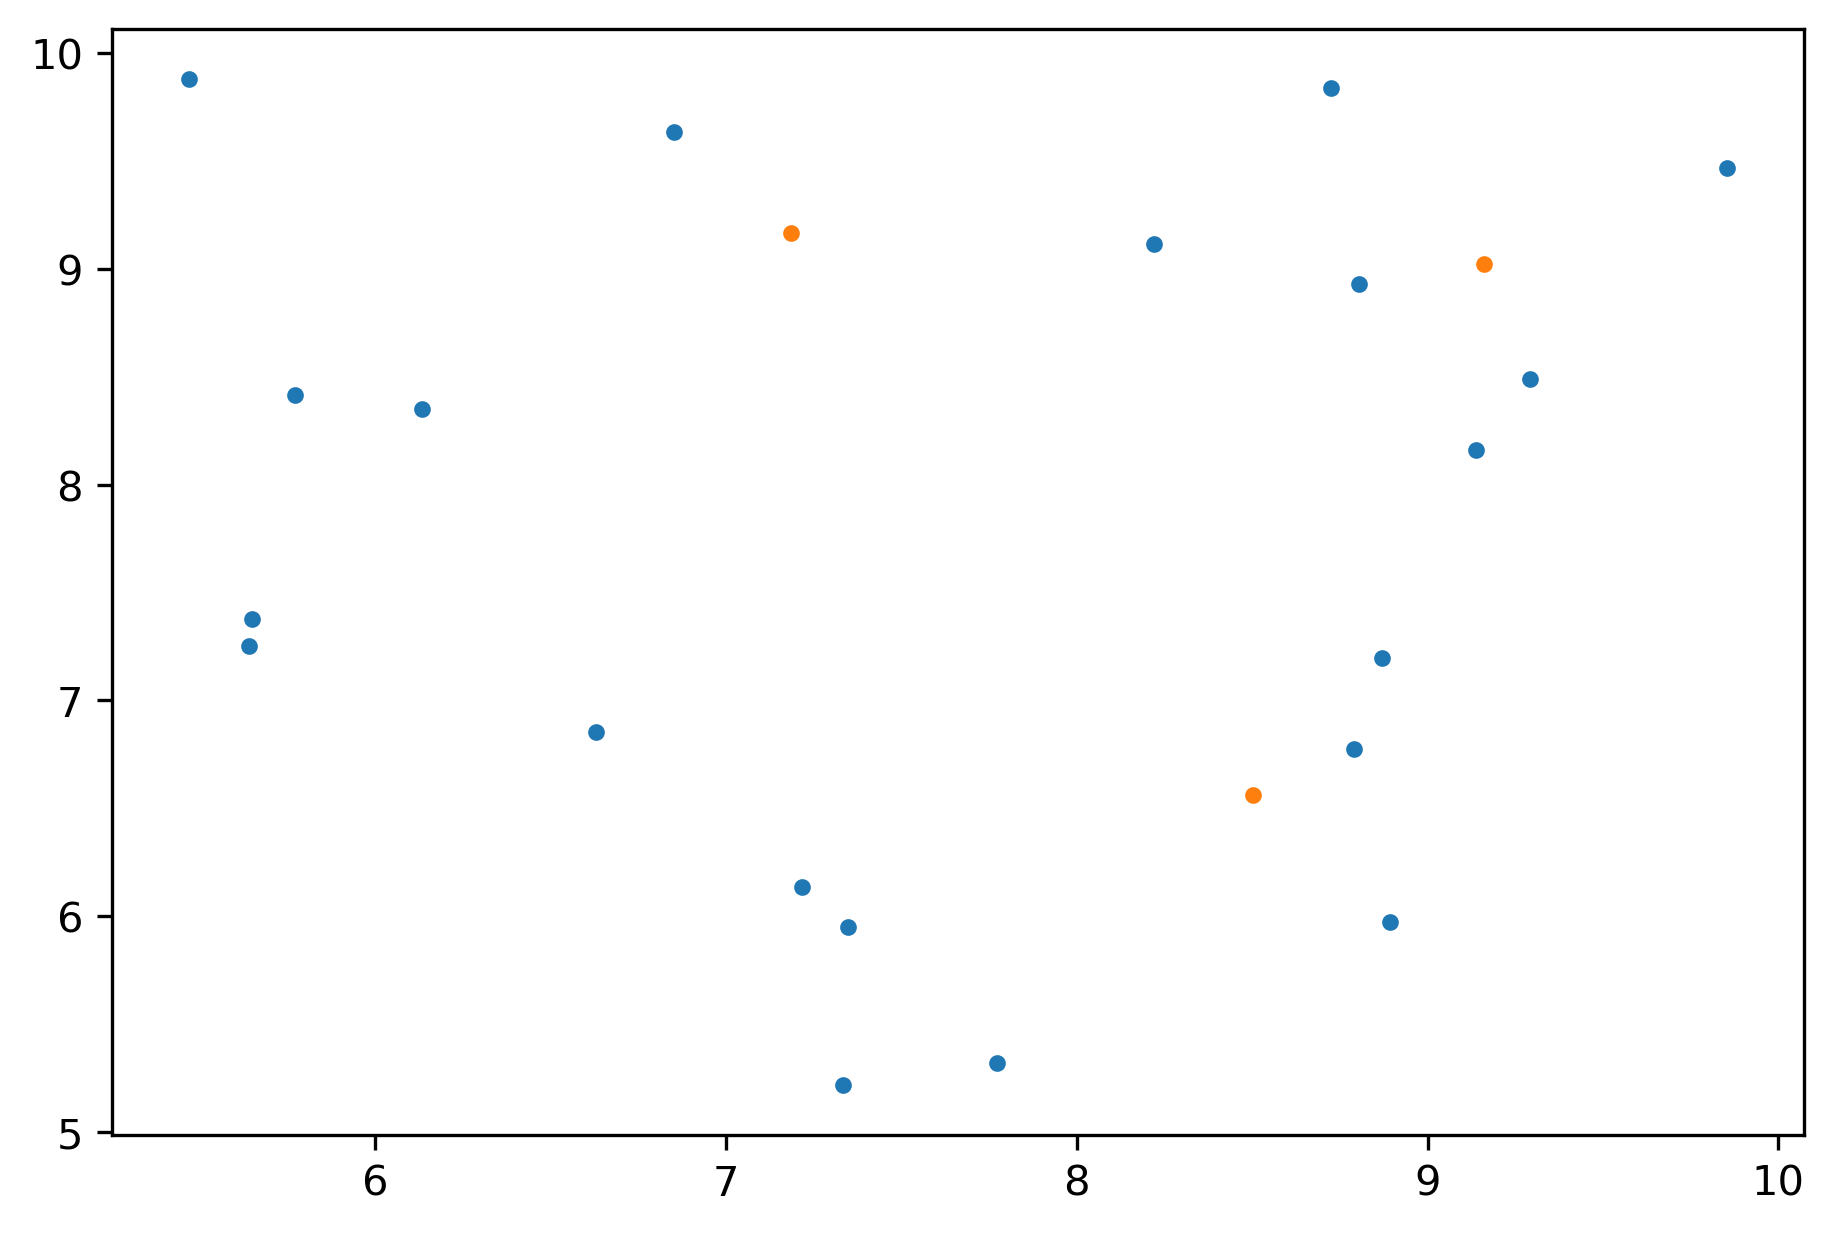

In [25]:
rng = np.random.default_rng(seed=42)

example_train_set = 5 * rng.random((20, 2)) + 5
example_test_set = 5 * rng.random((3, 2)) + 5

fig, ax = plt.subplots()

ax.plot(example_train_set[:, 0], example_train_set[:, 1], ".")
ax.plot(example_test_set[:, 0], example_test_set[:, 1], ".")

In [26]:
# Wrong!
scaled_train_set = MinMaxScaler().fit_transform(example_train_set)
# ...training...
scaled_test_set = MinMaxScaler().fit_transform(example_test_set)

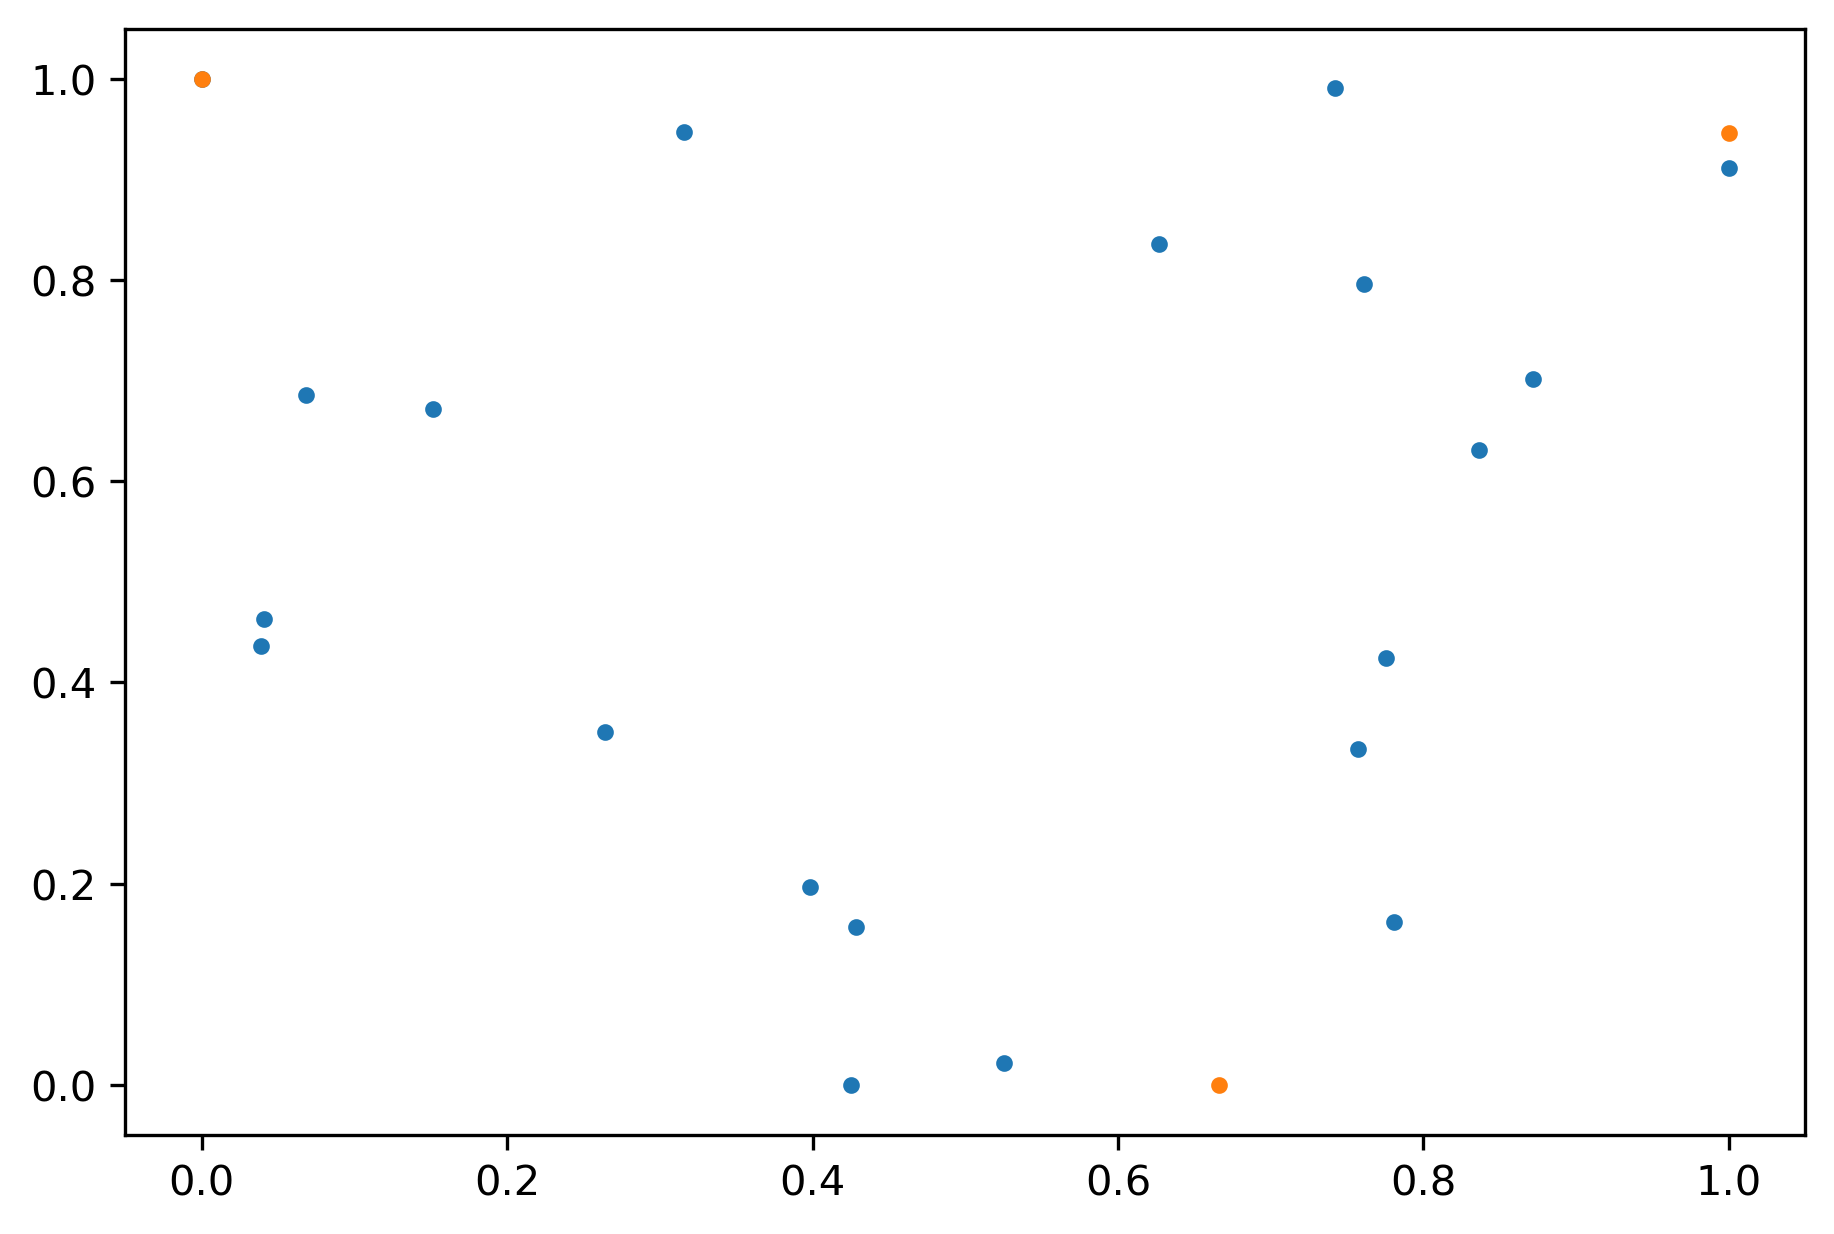

In [27]:
fig, ax = plt.subplots()

ax.plot(scaled_train_set[:, 0], scaled_train_set[:, 1], ".")
ax.plot(scaled_test_set[:, 0], scaled_test_set[:, 1], ".")

In [28]:
scaler = MinMaxScaler()
scaler.fit(example_train_set)
scaled_train_set = scaler.transform(example_train_set)
scaled_test_set = scaler.transform(example_test_set)

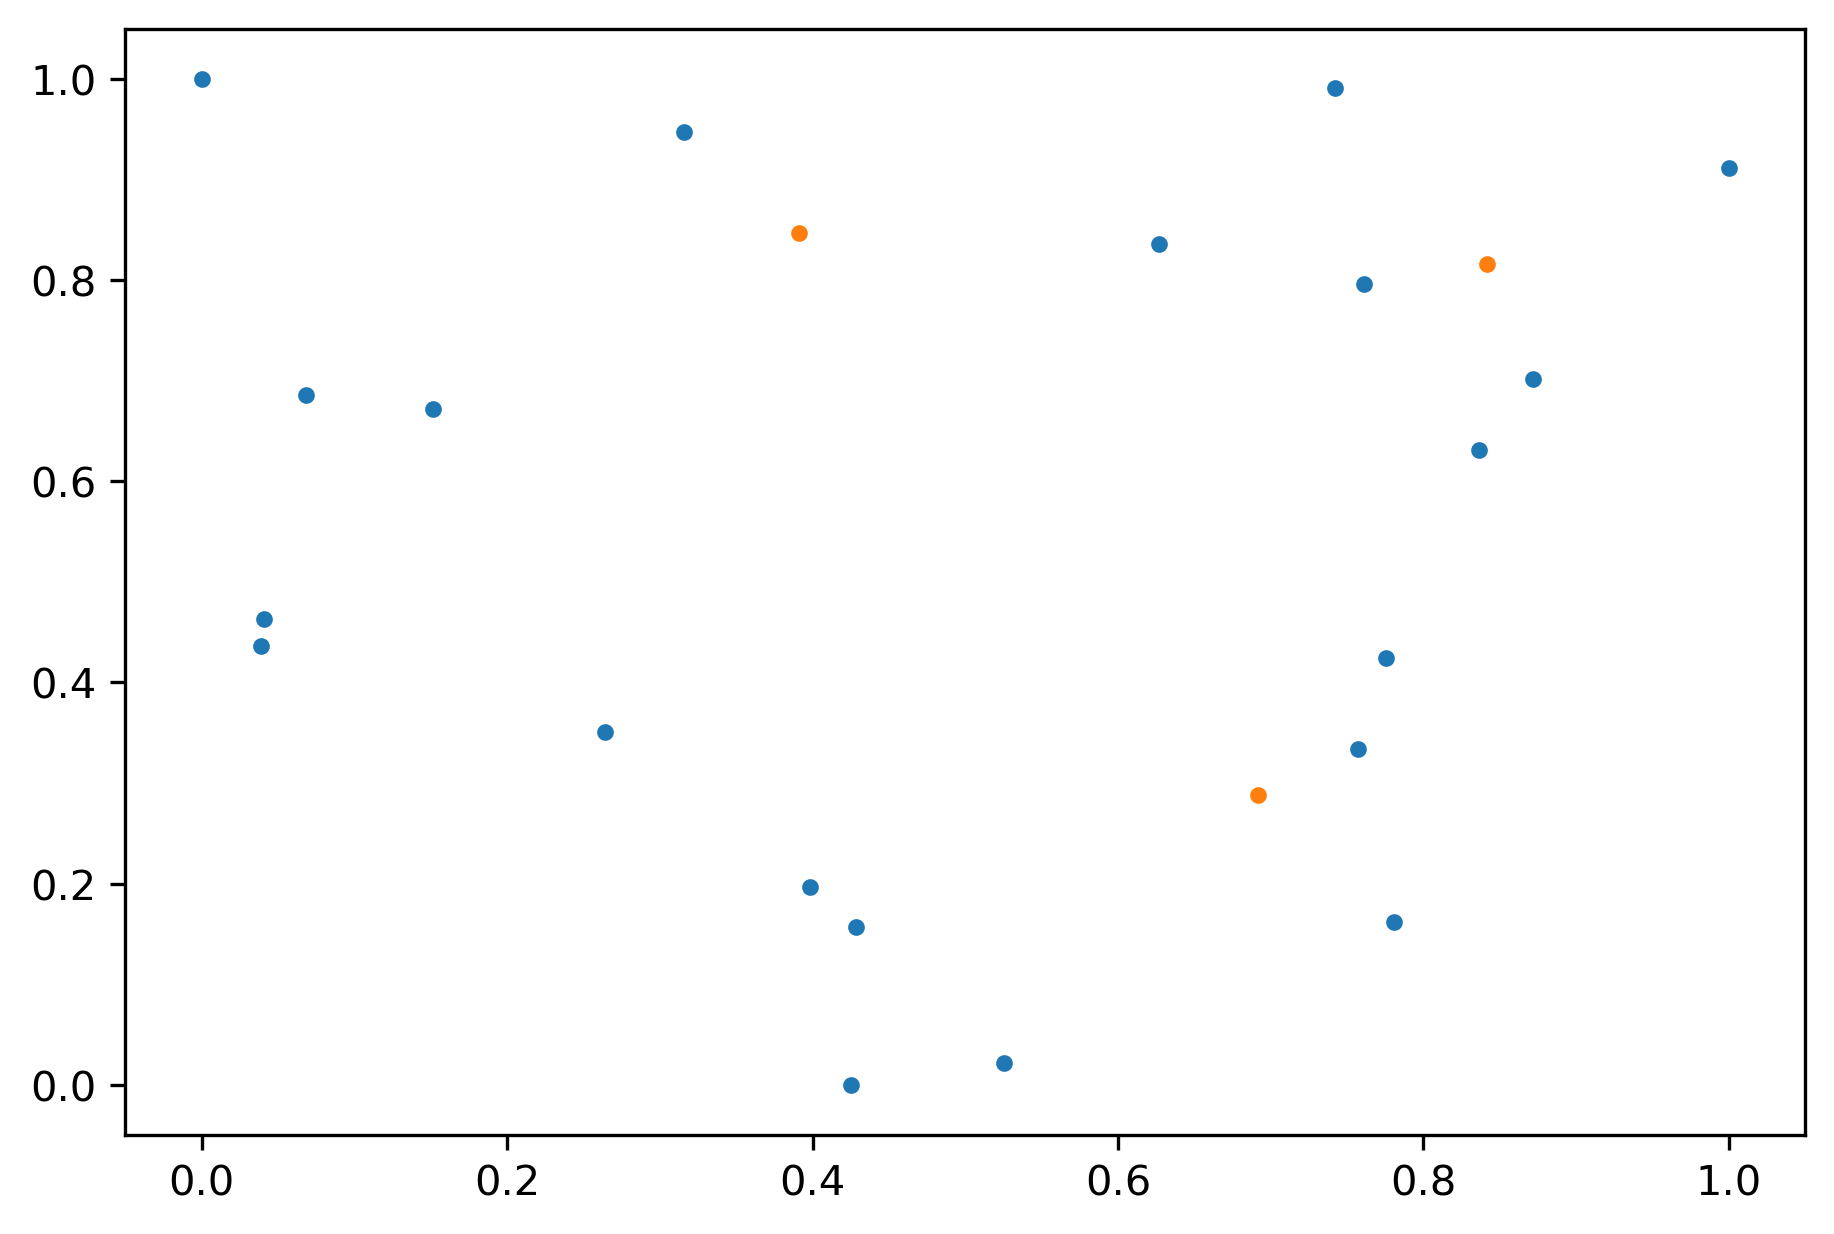

In [29]:
fig, ax = plt.subplots()

ax.plot(scaled_train_set[:, 0], scaled_train_set[:, 1], ".")
ax.plot(scaled_test_set[:, 0], scaled_test_set[:, 1], ".")

## 학습 (기본 XGBoost API 이용)

[XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [30]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.1,  # {0.3} learning rate
    "gamma": 1.0,  # {0} Minimum loss reduction
    "max_depth": 5,  # {6}
    "subsample": 0.5,  # {1} Row (sample) subsample ratio
    "colsample_bytree": 0.5,  # {1} Column (feature) subsample ratio
    "lambda": 1,  # {1} L2 regularization term
    "verbosity": 0,
}

In [31]:
def get_scores(y_true, y_pred):
    return {
        "accuracy": sklearn.metrics.accuracy_score(y_true, y_pred > 0.5),
        "log_loss": sklearn.metrics.log_loss(y_true, y_pred),
        "roc_auc": sklearn.metrics.roc_auc_score(y_true, y_pred),
    }

XGBoost는 자체적으로 `DMatrix` 형식의 데이터를 씁니다. ([Core Data Structure](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.core))

In [32]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [33]:
num_round = 200

bst = xgb.train(params, dtrain, num_boost_round=num_round)

In [34]:
y_pred_train = bst.predict(dtrain)
y_pred_test = bst.predict(dtest)

In [35]:
print("Train", get_scores(y_train, y_pred_train))
print("Test", get_scores(y_test, y_pred_test))

Train {'accuracy': 0.8908045977011494, 'log_loss': 0.2933481297816125, 'roc_auc': 0.9474465100505611}
Test {'accuracy': 0.8206106870229007, 'log_loss': 0.4212031219517172, 'roc_auc': 0.8670542635658917}


XGBoost에서 기본으로 제공하는 `plot_importance`를 이용해 F-score를 확인해 봅니다.

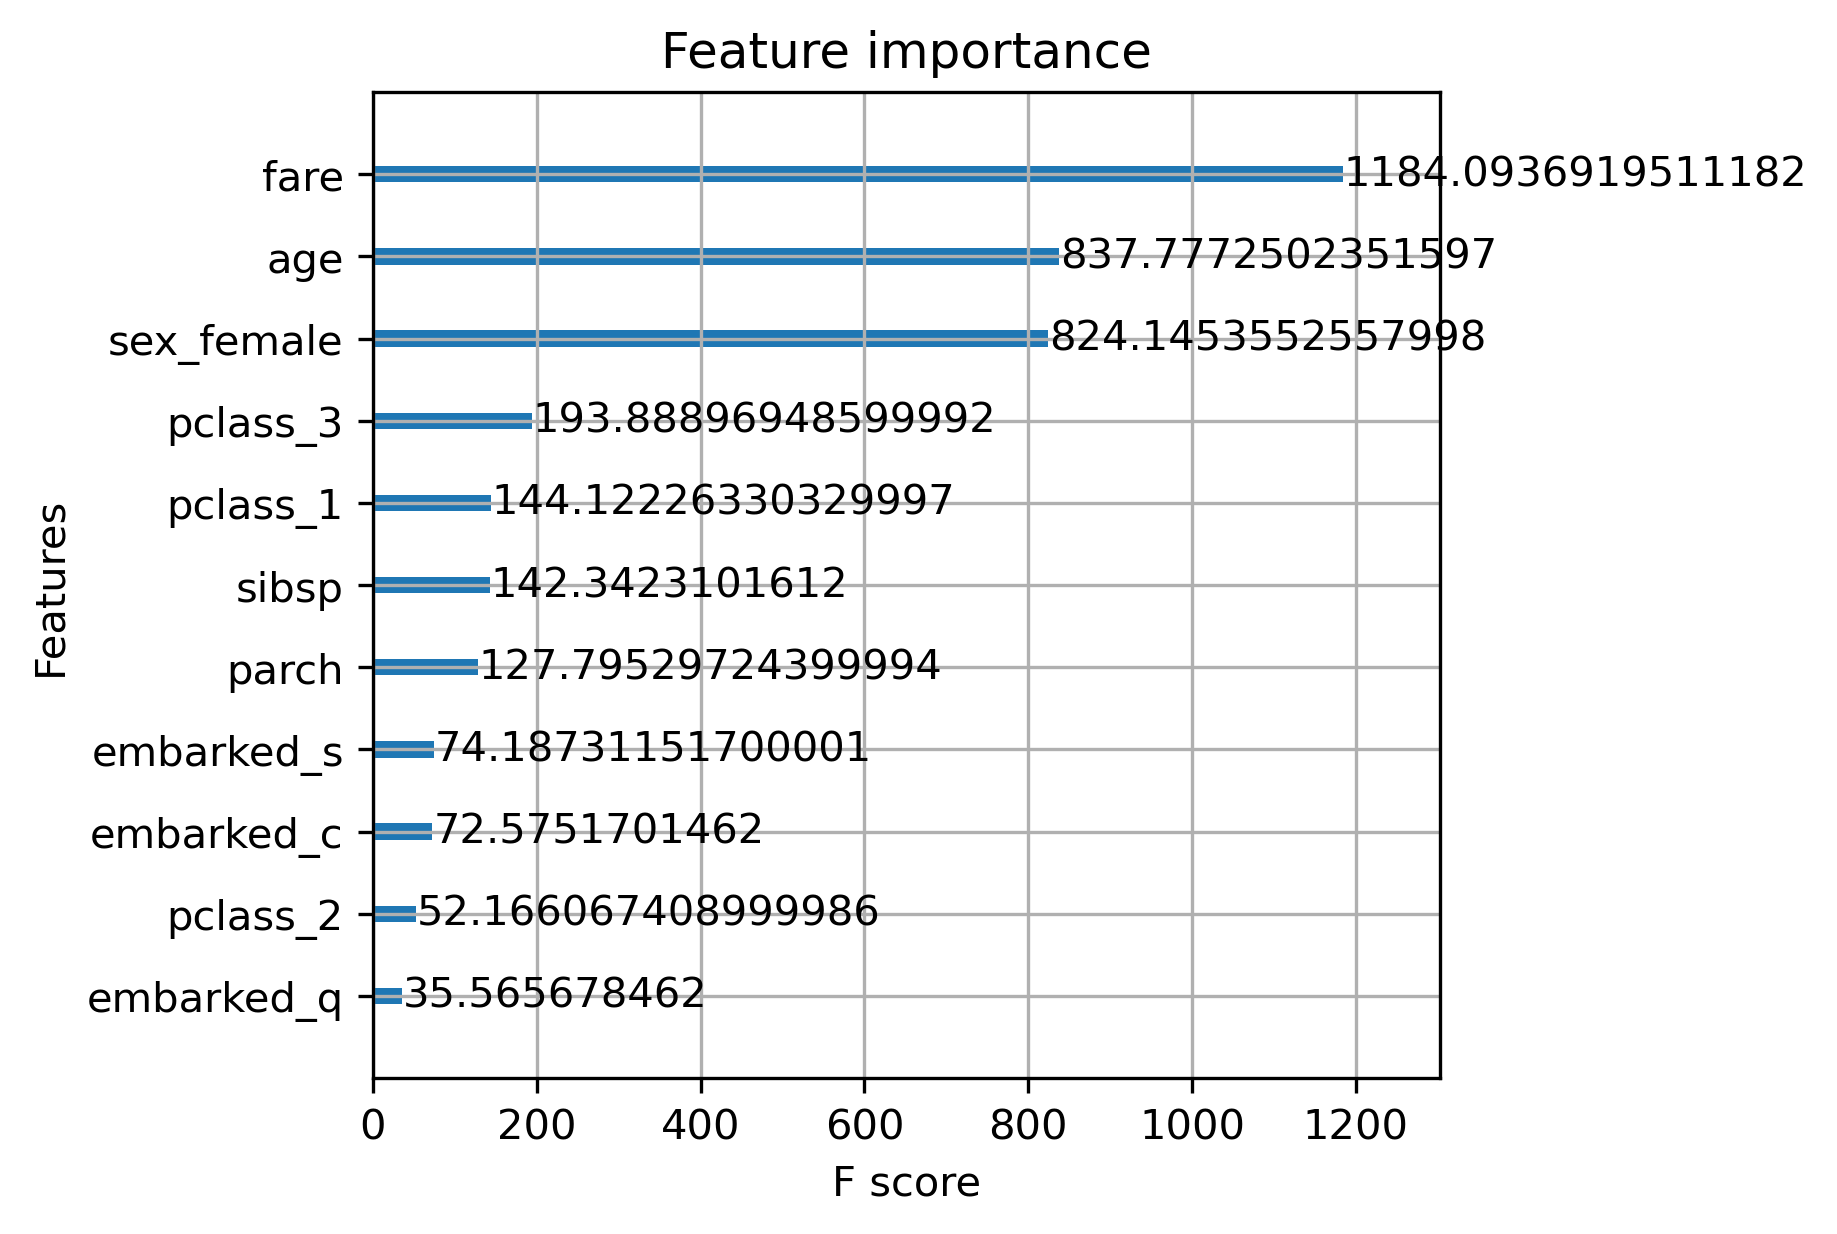

In [36]:
fig, ax = plt.subplots()

xgb.plot_importance(bst, importance_type="total_gain", ax=ax)
pass

부스터(학습된 모델)를 저장하고 불러오거나, 학습을 이어할 수 있습니다.

In [37]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [38]:
num_round = 200
num_round_per_loop = 5

bst = None
train_scores = []
test_scores = []
for i in range(num_round_per_loop, num_round + 1, num_round_per_loop):
    bst = xgb.train(params, dtrain, num_boost_round=5, xgb_model=bst)

    y_pred_train = bst.predict(dtrain)
    y_pred_test = bst.predict(dtest)
    train_scores.append(
        {
            "iteration": i,
            **{f"train_{k}": v for k, v in get_scores(y_train, y_pred_train).items()},
        }
    )
    test_scores.append(
        {
            "iteration": i,
            **{f"test_{k}": v for k, v in get_scores(y_test, y_pred_test).items()},
        }
    )

train_scores_df = pd.DataFrame(train_scores).set_index("iteration")
test_scores_df = pd.DataFrame(test_scores).set_index("iteration")

In [39]:
pd.concat((train_scores_df, test_scores_df), axis=1)

,train_accuracy,train_log_loss,train_roc_auc,test_accuracy,test_log_loss,test_roc_auc
iteration,,,,,,
5,0.803640,0.580519,0.860969,0.790076,0.577639,0.831460
10,0.818966,0.516780,0.866990,0.793893,0.517693,0.834205
15,0.818966,0.478598,0.873179,0.801527,0.484607,0.838727
20,0.821839,0.453359,0.883172,0.809160,0.464964,0.839503
25,0.818008,0.437591,0.885478,0.805344,0.454235,0.844089
30,0.820881,0.426165,0.888912,0.797710,0.447123,0.846512
35,0.821839,0.418666,0.890544,0.805344,0.443330,0.845090
40,0.823755,0.412424,0.891889,0.805344,0.440504,0.847028
45,0.823755,0.406914,0.894107,0.805344,0.437279,0.848966


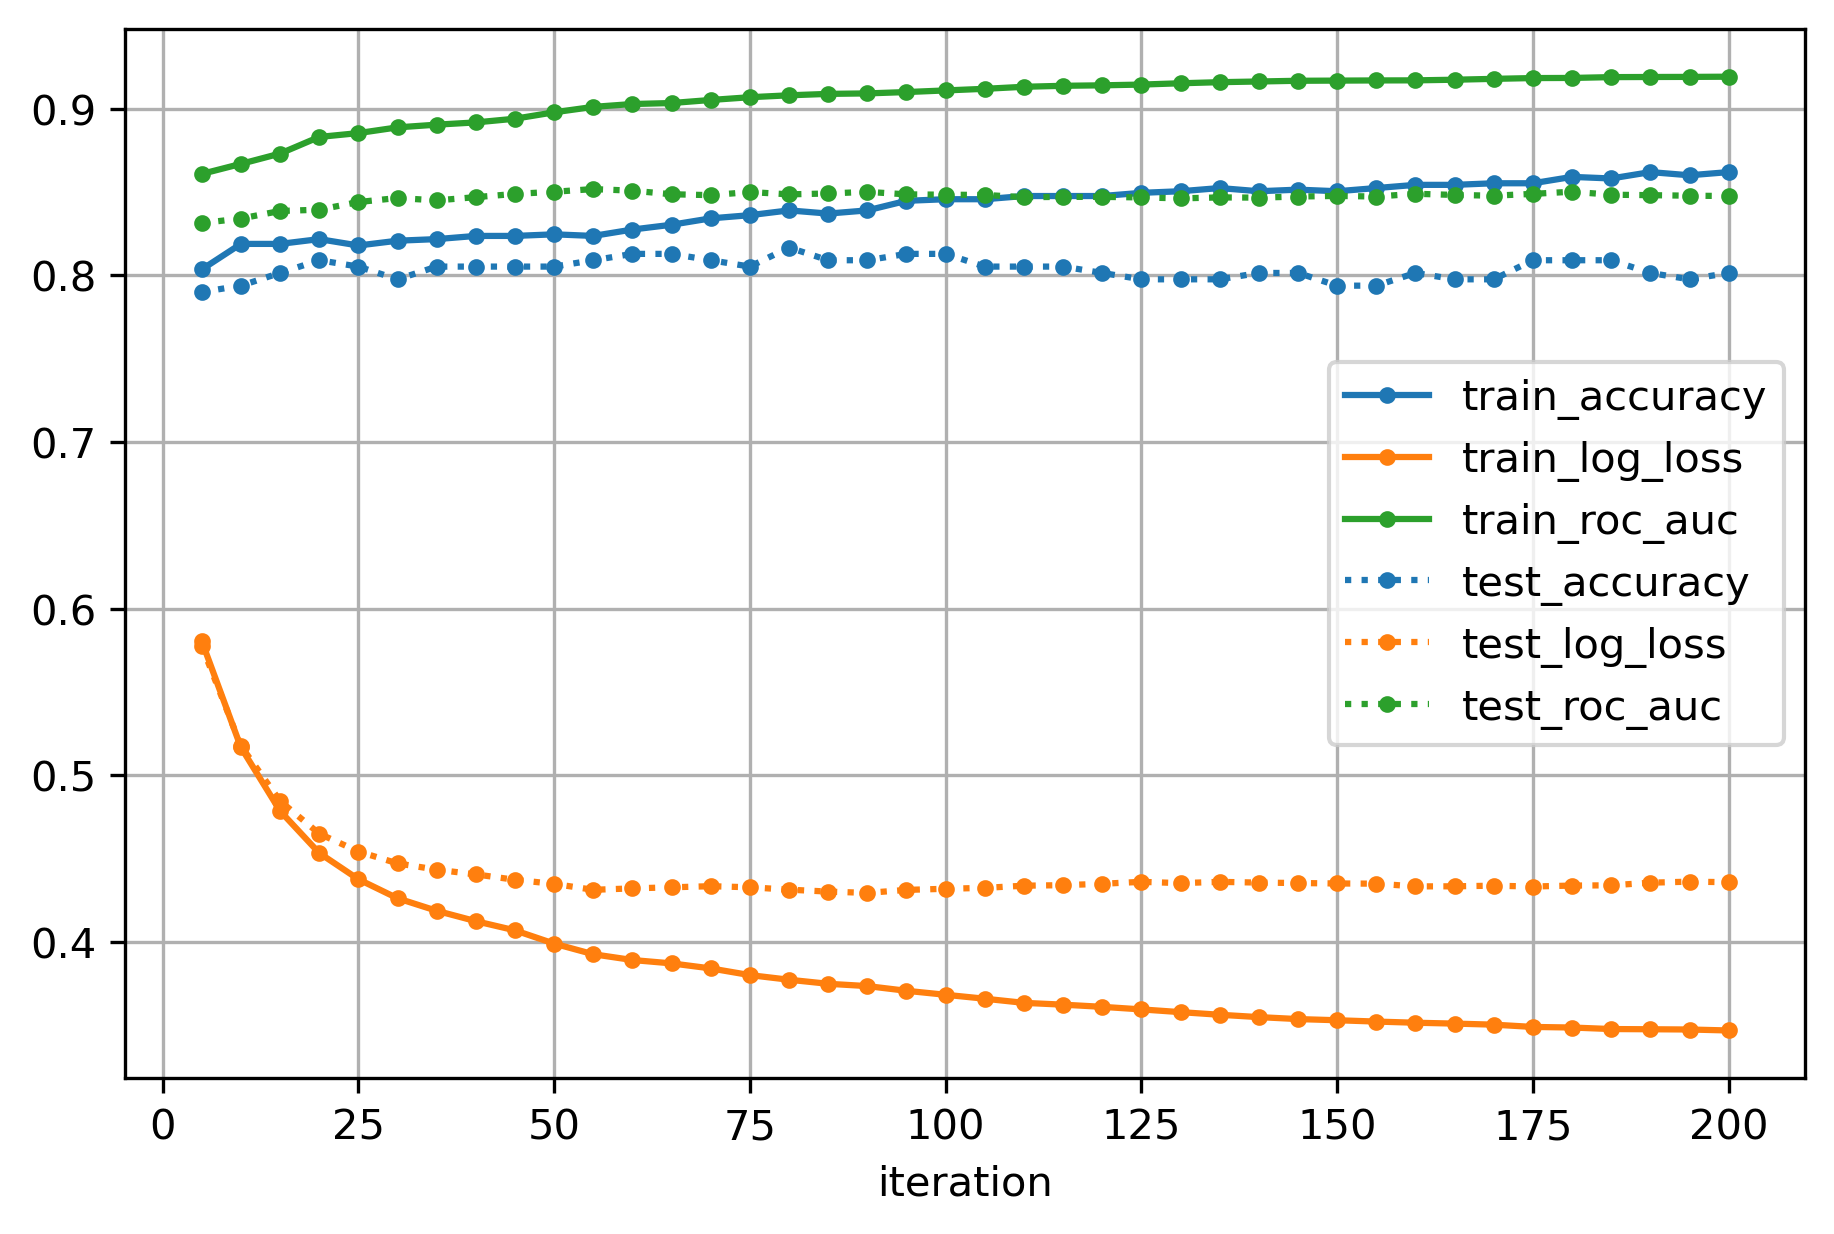

In [40]:
fig, ax = plt.subplots()

train_scores_df.plot(marker=".", ax=ax)
ax.set_prop_cycle(None)  # reset color cycle
test_scores_df.plot(marker=".", ls=":", ax=ax)
ax.grid()

### Early stopping

검증 세트를 주면 검증 세트의 점수가 더 나아지지 않으면 일찍 학습을 끊을수 있습니다.

In [41]:
(
    x_train_train,
    x_train_valid,
    y_train_train,
    y_train_valid,
) = sklearn.model_selection.train_test_split(x_train, y_train)

dtrain = xgb.DMatrix(x_train_train, label=y_train_train)
dvalid = xgb.DMatrix(x_train_valid, label=y_train_valid)
dtest = xgb.DMatrix(x_test, label=y_test)

In [42]:
num_round = 200

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=[(dvalid, "validset")],
    early_stopping_rounds=20,
)

[0]	validset-logloss:0.67649
Will train until validset-logloss hasn't improved in 20 rounds.
[1]	validset-logloss:0.65246
[2]	validset-logloss:0.62432
[3]	validset-logloss:0.61092
[4]	validset-logloss:0.60264
[5]	validset-logloss:0.59586
[6]	validset-logloss:0.59366
[7]	validset-logloss:0.58783
[8]	validset-logloss:0.58304
[9]	validset-logloss:0.57942
[10]	validset-logloss:0.57736
[11]	validset-logloss:0.55810
[12]	validset-logloss:0.54745
[13]	validset-logloss:0.53540
[14]	validset-logloss:0.53076
[15]	validset-logloss:0.52640
[16]	validset-logloss:0.51936
[17]	validset-logloss:0.51546
[18]	validset-logloss:0.51324
[19]	validset-logloss:0.51100
[20]	validset-logloss:0.51175
[21]	validset-logloss:0.51154
[22]	validset-logloss:0.51119
[23]	validset-logloss:0.51159
[24]	validset-logloss:0.50777
[25]	validset-logloss:0.50367
[26]	validset-logloss:0.50466
[27]	validset-logloss:0.50430
[28]	validset-logloss:0.50425
[29]	validset-logloss:0.50472
[30]	validset-logloss:0.50378
[31]	validset-lo

## Scikit-learn wrapper API

XGBoost에서는 scikit-learn의 pipeline 등에 넣어서 scikit-learn의 estimator처럼 쓸 수 있는 wrapper 인터페이스를 제공합니다.

In [43]:
titanic_transformer = FunctionTransformer(titanic_one_hot_encoder)

In [44]:
titanic_transformer.fit(x_train_raw)

one_hot_encoded_column_names = titanic_transformer.transform(x_train_raw).columns

display(titanic_transformer.transform(x_train_raw).head())
display(titanic_transformer.transform(x_test_raw).head())

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,embarked_c,embarked_q,embarked_s
872,50.0,1,0,26.0000,0,1,0,0,0,0,1
1251,50.0,0,1,247.5208,1,0,0,1,1,0,0
771,NaN,0,0,31.6833,1,0,0,1,0,0,1
574,36.0,1,0,26.0000,0,1,0,1,0,0,1
786,39.0,0,0,7.9250,0,0,1,0,0,0,1


,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,embarked_c,embarked_q,embarked_s
644,1.0,0,2,37.0042,0,1,0,0,1,0,0
1144,36.0,1,0,17.4000,0,0,1,1,0,0,1
900,51.0,0,0,12.5250,0,1,0,0,0,0,1
398,18.0,0,0,6.7500,0,0,1,1,0,1,0
457,25.0,0,0,7.8958,0,0,1,0,0,0,1


In [45]:
params = {
    "objective": "binary:logistic",
    "n_estimators": 200,
    "learning_rate": 0.3,  # {0.3} learning rate
    "gamma": 1.0,  # {0} Minimum loss reduction
    "max_depth": 5,  # {6}
    "subsample": 0.5,  # {1} Row (sample) subsample ratio
    "colsample_bytree": 1.0,  # {1} Column (feature) subsample ratio
    "reg_lambda": 1,  # {1} L2 regularization term
    "verbosity": 0,
}

In [46]:
pipe = Pipeline(
    [
        ("one_hot", FunctionTransformer(titanic_one_hot_encoder)),
        # Optional: Fill NA values
        # ("mean_imputer", SimpleImputer()),
        # ("dim_reducer", SelectKBest(sklearn.feature_selection.chi2)),
        # Select one
        ("clf", XGBClassifier(**params)),
        # ("clf", HistGradientBoostingClassifier()),
    ]
)
pipe

Pipeline(steps=[('one_hot',
                 FunctionTransformer(func=<function titanic_one_hot_encoder at 0x0000022DCD6D8CA0>)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=1.0, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None, reg_lambda=1,
                               scale_pos_weight=None, subsample=0.5,
                               tree_method=None, validate_parameters=

In [47]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    x_train_raw, y_train_raw
)

x_test = x_test_raw.copy()
y_test = y_test_raw.copy()

In [48]:
x_train.head()

,age,sibsp,parch,fare,pclass,sex,embarked
818,19.0,0,0,8.050,3,male,S
1286,59.0,0,0,7.250,3,male,S
188,64.0,1,4,263.000,1,male,S
919,6.0,4,2,31.275,3,female,S
256,24.0,0,0,7.250,3,male,Q


In [49]:
pipe.fit(x_train, y_train)
pass

In [50]:
get_scores(y_test, pipe.predict_proba(x_test)[:, 1])

{'accuracy': 0.7748091603053435,
 'log_loss': 0.5310189070396448,
 'roc_auc': 0.8409883720930232}

### 파라미터 최적화

In [51]:
param_grid = {
    # "dim_reducer__k": [5, 7],  # uncomment only if dim_reducer is in the pipeline
    "clf__learning_rate": [0.01, 0.03, 0.1],
    "clf__colsample_bytree": [0.3, 0.5, 1.0],
}

In [52]:
gs = GridSearchCV(pipe, param_grid, scoring="neg_log_loss")

gs.fit(x_train, y_train)
pass

In [53]:
gs.predict(x_test)

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 0.

In [54]:
get_scores(y_test, gs.predict_proba(x_test)[:, 1])

{'accuracy': 0.8129770992366412,
 'log_loss': 0.43179605550751204,
 'roc_auc': 0.8566214470284237}

In [55]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__colsample_bytree,param_clf__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.174250,0.010759,0.033851,0.003619,0.3,0.01,"{'clf__colsample_bytree': 0.3, 'clf__learning_...",-0.542554,-0.509144,-0.503316,-0.500540,-0.515984,-0.514308,0.015084,9
1,0.165576,0.010885,0.031921,0.003285,0.3,0.03,"{'clf__colsample_bytree': 0.3, 'clf__learning_...",-0.521053,-0.480105,-0.440773,-0.416088,-0.460620,-0.463728,0.035667,4
2,0.164898,0.013176,0.034525,0.004470,0.3,0.1,"{'clf__colsample_bytree': 0.3, 'clf__learning_...",-0.551598,-0.525303,-0.424741,-0.381394,-0.467750,-0.470157,0.062643,5
3,0.175078,0.012866,0.032865,0.003274,0.5,0.01,"{'clf__colsample_bytree': 0.5, 'clf__learning_...",-0.521619,-0.496271,-0.476198,-0.454048,-0.478885,-0.485404,0.022539,7
4,0.166958,0.005297,0.030118,0.000444,0.5,0.03,"{'clf__colsample_bytree': 0.5, 'clf__learning_...",-0.520176,-0.499787,-0.429622,-0.388275,-0.436988,-0.454970,0.048320,1
5,0.171029,0.007753,0.029273,0.001934,0.5,0.1,"{'clf__colsample_bytree': 0.5, 'clf__learning_...",-0.574765,-0.553573,-0.423864,-0.374924,-0.462971,-0.478019,0.075969,6
6,0.188821,0.010598,0.031892,0.003289,1,0.01,"{'clf__colsample_bytree': 1.0, 'clf__learning_...",-0.509503,-0.482680,-0.462792,-0.396019,-0.436038,-0.457407,0.039005,2
7,0.184444,0.011015,0.033925,0.003715,1,0.03,"{'clf__colsample_bytree': 1.0, 'clf__learning_...",-0.541231,-0.498011,-0.456378,-0.368294,-0.440281,-0.460839,0.058055,3
8,0.174429,0.007981,0.028436,0.004646,1,0.1,"{'clf__colsample_bytree': 1.0, 'clf__learning_...",-0.603315,-0.568774,-0.458077,-0.387649,-0.474539,-0.498471,0.078001,8


In [56]:
gs.best_params_

{'clf__colsample_bytree': 0.5, 'clf__learning_rate': 0.03}

In [57]:
gs.best_estimator_["clf"]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=0)

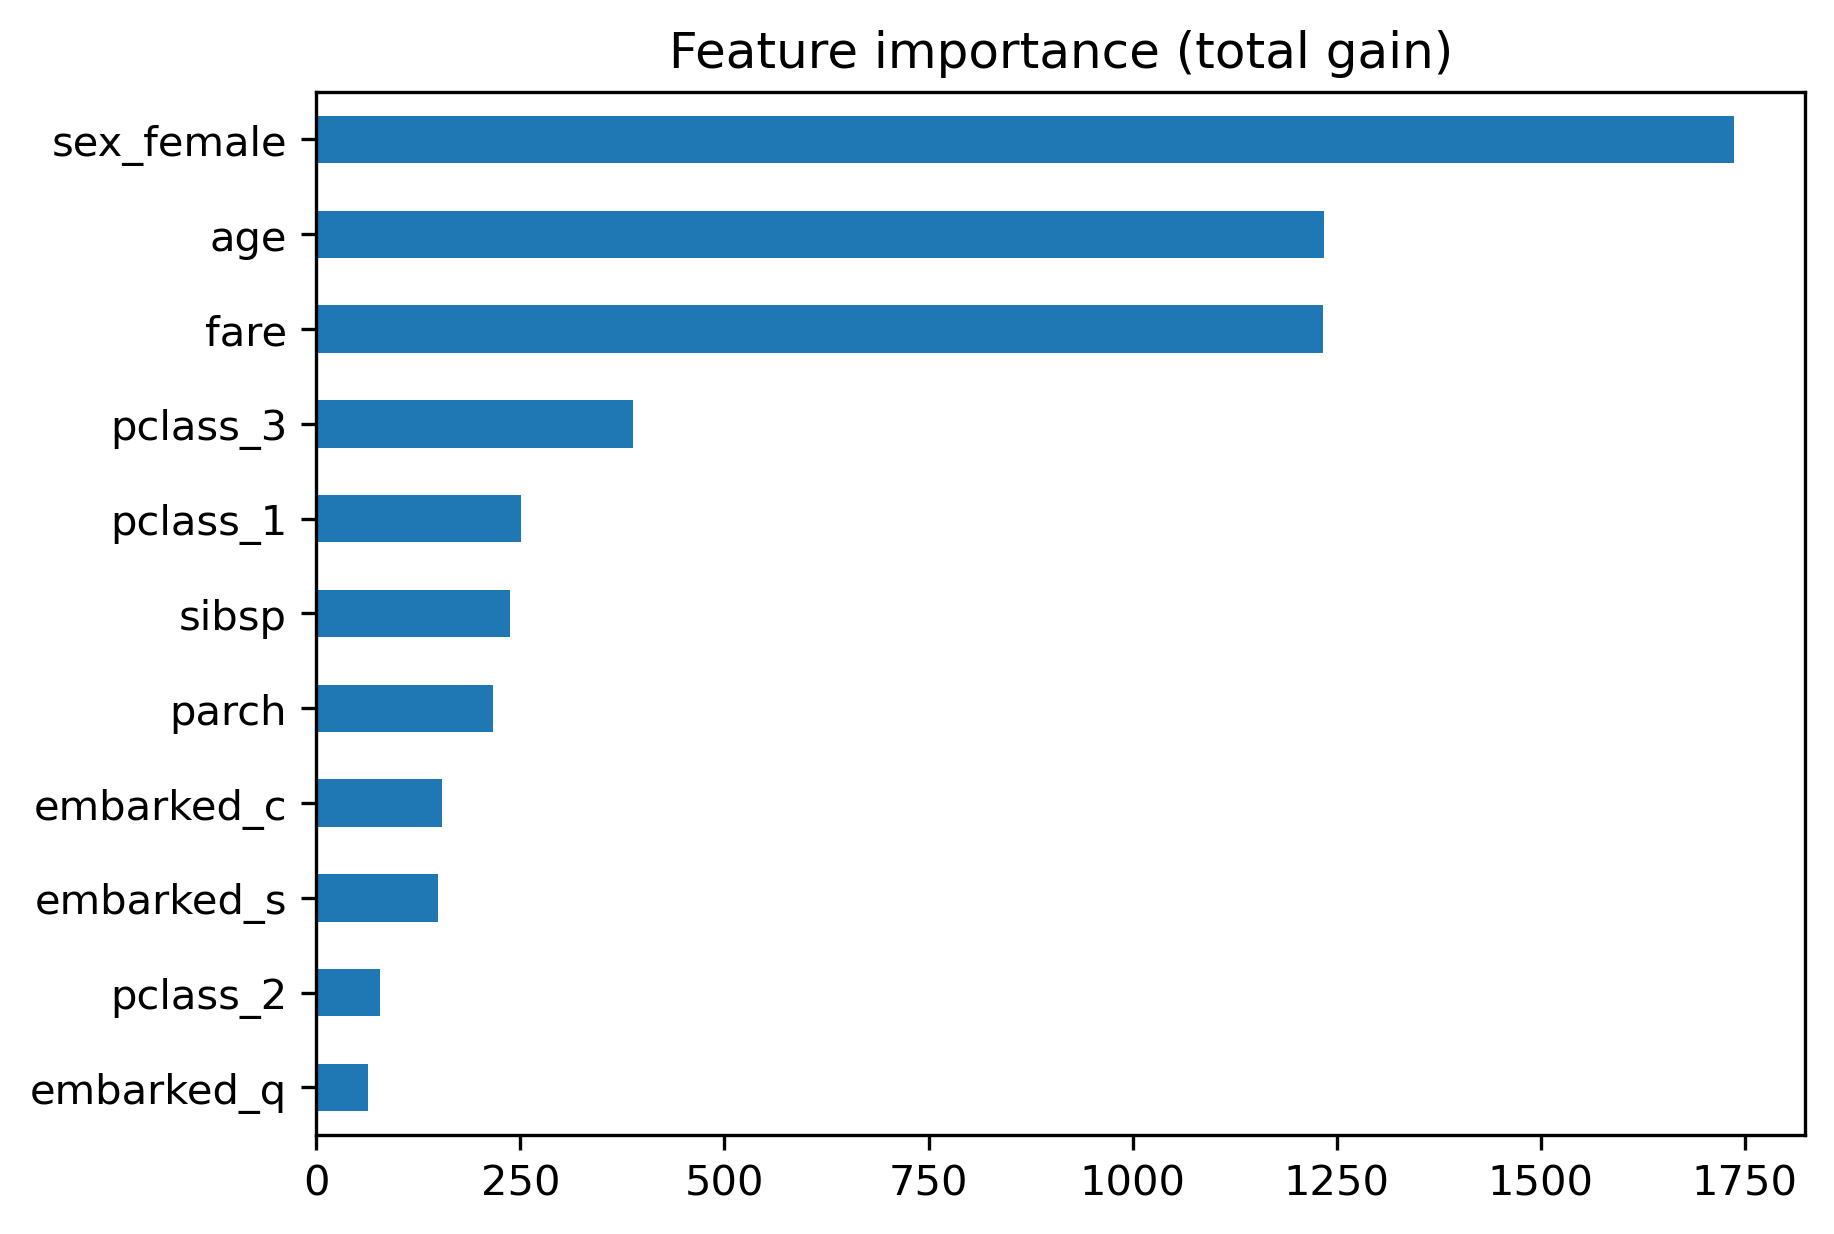

In [58]:
bst = gs.best_estimator_["clf"].get_booster()
importance = pd.Series(bst.get_score(importance_type="total_gain"))
# Restore feature names
if "dim_reducer" in gs.best_estimator_.named_steps:
    importance = importance.rename(
        {
            f"f{i}": one_hot_encoded_column_names[ci]
            for i, ci in enumerate(
                gs.best_estimator_["dim_reducer"].get_support(indices=True)
            )
        }
    )

fig, ax = plt.subplots()
importance.sort_values().plot.barh(ax=ax)
ax.set(title="Feature importance (total gain)")
pass